# Laboratorio 2 - Clasificación y Regresión

En este laboratorio trabajaremos con algoritmos de clustering y reglas de asociación sobre 3 datasets:

1. __E-Commerce Data:__ Este dataset contiene transacciones realizadas por una empresa de e-commerce en distintos paises. Lo puede encontrar en el siguiente [link](https://www.kaggle.com/datasets/carrie1/ecommerce-data)
2. __Bank Customer Churn:__ Este dataset contiene información de clientes de un banco, dentro de esta base se encuentran tanto clientes fugados como no fugados. Puede encontrar el dataset en el siguiente [link](https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn)
3. __Global poverty and inequality dataset:__ Este daataset contiene información socio-demográfica proveniente del banco mundial referente a varios paises. Puede encontrar el dataset en el siguiente [link](https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset?select=pip_dataset.csv)


In [253]:
import opendatasets as od
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

import numpy as np

import scipy
from scipy.stats import gaussian_kde

In [254]:
"""Descargamos los datasets
od.download("https://www.kaggle.com/datasets/carrie1/ecommerce-data")
od.download("https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn")
od.download("https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset?select=pip_dataset.csv")
"""

'Descargamos los datasets\nod.download("https://www.kaggle.com/datasets/carrie1/ecommerce-data")\nod.download("https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn")\nod.download("https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset?select=pip_dataset.csv")\n'

In [255]:
#Cargar csv's
bank_df= pd.read_csv("bank-customer-churn/Customer-Churn-Records.csv")
ecom_df=df = pd.read_csv("ecommerce-data/data.csv", encoding= 'unicode_escape')
poverty_df= df = pd.read_csv("global-poverty-and-inequality-dataset/pip_dataset.csv")


# Preguntas

## 1. Bank Customer Churn (35 pts)
Es de interés saber qué perfil tienen los clientes que más se fugan del banco y aquellos que son más leales (menos fuga). Resuelva este problema usando modelos de clustering y posteriormente ajuste algún modelo de clasificación, validándolos según las métricas vistas en clases para ambos tipos de problemas. Discuta el desempeño por separado de ambos modelos en su respectivo problema y discuta con qué aproximación se quedaría usted para reportar los perfiles. ¿Cómo describiría usted los perfiles encontrados? (si son muchos basta discutir los que poseen mayor cantidad de elementos).



In [256]:
bank_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# Limpieza del dataset

In [257]:
bank_df.columns = [i.lower().replace(' ','_') for i in bank_df.columns]

In [258]:
print("Tiene algun elemento vacio? : {}".format(bank_df.isnull().any().any()))

Tiene algun elemento vacio? : False


In [259]:
# Drop unnecessary columns
bank_df = bank_df.drop(columns = ['rownumber','customerid', "surname"])

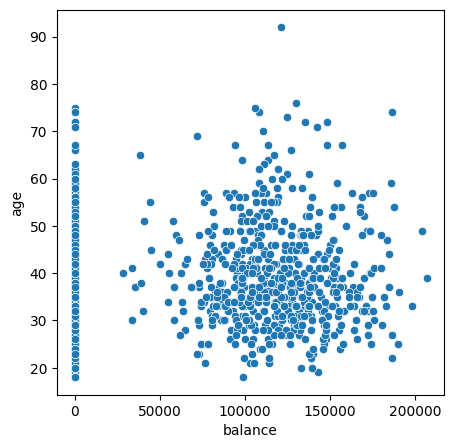

In [260]:
df = bank_df.sample(1000)

fig = plt.figure(figsize = (5,5))
ax = sns.scatterplot(df, x="balance", y = "age")


# No hay gente de alemania con balance 0?

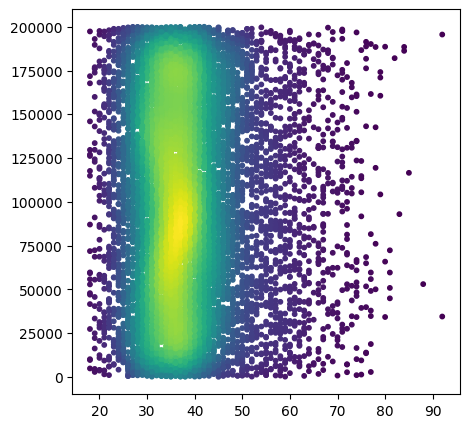

In [261]:



x = bank_df["age"]
y = bank_df["estimatedsalary"]



# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(x, y, c=z, s=10)
plt.show()

In [262]:
def discretizar_columna(dataframe, columname):
    lista_a_buscar = dataframe[columname].unique().tolist()
    lista = []

    for val in dataframe[columname]:
        lista.append(lista_a_buscar.index(val))
    
    dataframe["d_"+columname] = lista
    dataframe = dataframe.drop(columns = [columname])

    return dataframe

In [263]:
bank_df

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction_score,card_type,point_earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339


In [264]:
bank_df = discretizar_columna(bank_df, "geography")
bank_df = discretizar_columna(bank_df, "gender")
bank_df = discretizar_columna(bank_df, "card_type")
bank_df

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction_score,point_earned,d_geography,d_gender,d_card_type
0,619,42,2,0.00,1,1,1,101348.88,1,1,2,464,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,3,456,1,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,3,377,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,5,350,0,0,1
4,850,43,2,125510.82,1,1,1,79084.10,0,0,5,425,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,1,300,0,1,0
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,5,771,0,1,3
9997,709,36,7,0.00,1,0,1,42085.58,1,1,3,564,0,0,2
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,2,339,2,1,1


## KMEANS method 

Cosas que podemos hacer:
- Hacer una funcion que copie el dataframe, y reciba un k = K para crear el kmeans clustering, y que imprima los scatter plot necesarios para mostrar esa division
- Copiar el dataframe
- Predecir con km.fit_predict
- Agregar columna a copia de df
- Opcion 1: Devolver el dataframe (y llamar una funcionq ue printee)
- Opcion 2: Producir el gráfico.

Ojalá la funcion retorne las metricas de kmeans tambien.

[1 1 2 ... 1 0 2]


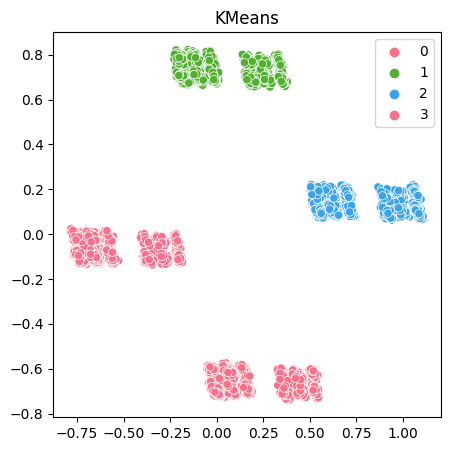

In [306]:
"""
Nombre función: KMeans_core
Parámetros:
    - num_clusters: Entero, Numero de clusters que queremos generar
    - dataframe: DataFrame a analizar
    - col1: String, nombre de la 1era columna a utilizar para el clustering.
    - col2: String, nombre de la 2da columna a utilizar para el clustering.
Tarea funcion: Genera los 'num_clusters' clusters del DataFrame 'dataframe', en base a las columnas 'col1' y 'col2'. Se separa el DataFrame en cada cluster y se almacena en la lista 'clustersDataFrames'
Retorno: Listado de Dataframes 'clustersDataFrames' y el objeto 'km' de KMeans con los parametros dados.
"""
pd.reset_option("mode.chained_assignment")
    
def print_elbow_KM(array_pcas, array_models):
    
    fig = plt.figure(figsize=(20,20))

    for i,data_pca in enumerate(array_pcas):
        ax = fig.add_subplot(5,3,i+1)
        ax = sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=array_models[i].labels_, palette="husl")
        ax.set_title("KMeans " +str(i+1)+" clusters")

def print_KM(data_pca, model):
    fig = plt.figure(figsize=(5, 5))
    ax = sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=model.labels_, palette="husl" )
    ax.set_title("KMeans")
    plt.show()

def KMeans_core(num_clusters, og_dataframe):
    dataframe = og_dataframe
    dataframe = dataframe.drop(columns=["exited"])

    # Scaling
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(dataframe)

    # Descomponemos el dataset en columnas representativas a traves de PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)
    
    # KMEans model
    km = KMeans(n_clusters=num_clusters, n_init=10)
    model = km.fit(data_pca)

    y_pred = model.labels_.astype(int)
    print (y_pred)
    
    dataframe["cluster"] = y_pred
    clustersDataFrames=[]
    for eachCluster in range(num_clusters):
        clustersDataFrames.append(dataframe[dataframe.cluster==eachCluster])
    return clustersDataFrames, model, dataframe, data_pca


clusters, km, dataframe, data_pca = KMeans_core(4, bank_df)

print_KM(data_pca, km)



In [276]:
dataframe

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,complain,satisfaction_score,point_earned,d_geography,d_gender,d_card_type,cluster
0,619,42,2,0.00,1,1,1,101348.88,1,2,464,0,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,1,3,456,1,0,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,3,377,0,0,0,2
3,699,39,1,0.00,2,0,0,93826.63,0,5,350,0,0,1,2
4,850,43,2,125510.82,1,1,1,79084.10,0,5,425,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,1,300,0,1,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,5,771,0,1,3,3
9997,709,36,7,0.00,1,0,1,42085.58,1,3,564,0,0,2,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,2,339,2,1,1,1


[3 3 1 ... 3 2 1]
[3, 1, 2, 0]


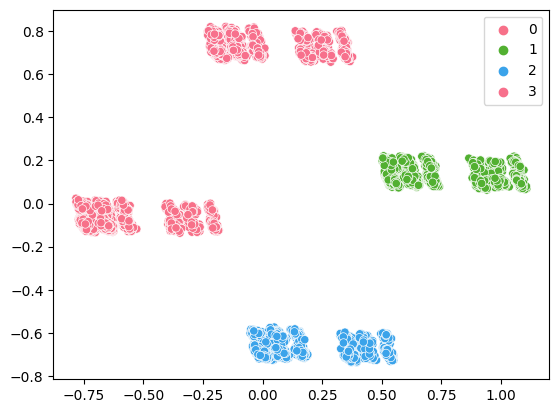

In [280]:

def Cluster_Stats(nClusters, dataframe, col1, col2):
    km=KMeans(n_clusters=nClusters, n_init=10)
    km.fit(dataframe[[col1, col2]])
    #print(" ..:: Estadisticas: ::.. ")
    #print (km.inertia_)


"""
Nombre función: ClustersPrinter
Parámetros:
    - clustersDataFrame: Lista de DataFrames, obtenido de la generacion de clusters en la funcion 'KMeans_core'
    - col1: String, nombre de la 1era columna a utilizada para el clustering.
    - col2: String, nombre de la 2da columna a utilizada para el clustering.
    - km: Objeto 'km' de KMeans con los parametros dados
Tarea funcion: Grafica el scatterplot, diferenciando los clusters y sus centroides respectivos.
Retorno: Nada.
"""
def ClustersPrinter(clustersDataFrames, dataframe, col1, col2, km):
    colors = ["red", "green", "blue", "yellow", "orange", "purple", "pink", "brown", "gray", "teal"]
    colorizer=0
    for clusteredDataFrame in clustersDataFrames:
        plt.scatter(clusteredDataFrame[col1], clusteredDataFrame[col2], color= colors[colorizer%10])
        colorizer+=1
    plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color="black", marker="*", label="Centroide") #ESTOS CENTROIDES SON LOS QUE GENERAN EL PROBLEMA, NO ESTAN AJUSTADOS A LOS VALORES AJUSTADOS
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend()
    Cluster_Stats(len(clustersDataFrames), dataframe, col1, col2 )
clusters, km, fitted_df, pca_df = KMeans_core(4, bank_df)





fitted_df
print(fitted_df.cluster.unique().tolist())

### Elbow Method

In [281]:
def elbowPrinter(k_rng, sse):
    plt.xlabel("K")
    plt.ylabel("Sum of squared error")
    plt.plot(k_rng, sse)

In [293]:
k_rng = range(1,10)
sse = []
array_pca, array_km = [], []

for k in k_rng:
    clusters, km, fitted_df, data_pca=KMeans_core(k, bank_df)
    sse.append(km.inertia_)
    array_pca.append(data_pca)
    array_km.append(km)



[0 0 0 ... 0 0 0]
[1 1 1 ... 1 0 1]
[1 1 1 ... 1 2 1]
[3 3 1 ... 3 0 1]
[3 3 0 ... 3 2 4]
[0 0 4 ... 0 5 3]
[5 5 6 ... 5 4 0]
[6 6 4 ... 6 5 1]
[6 6 4 ... 6 5 0]


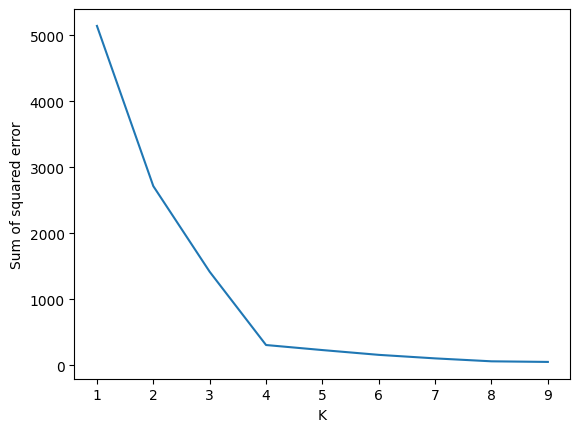

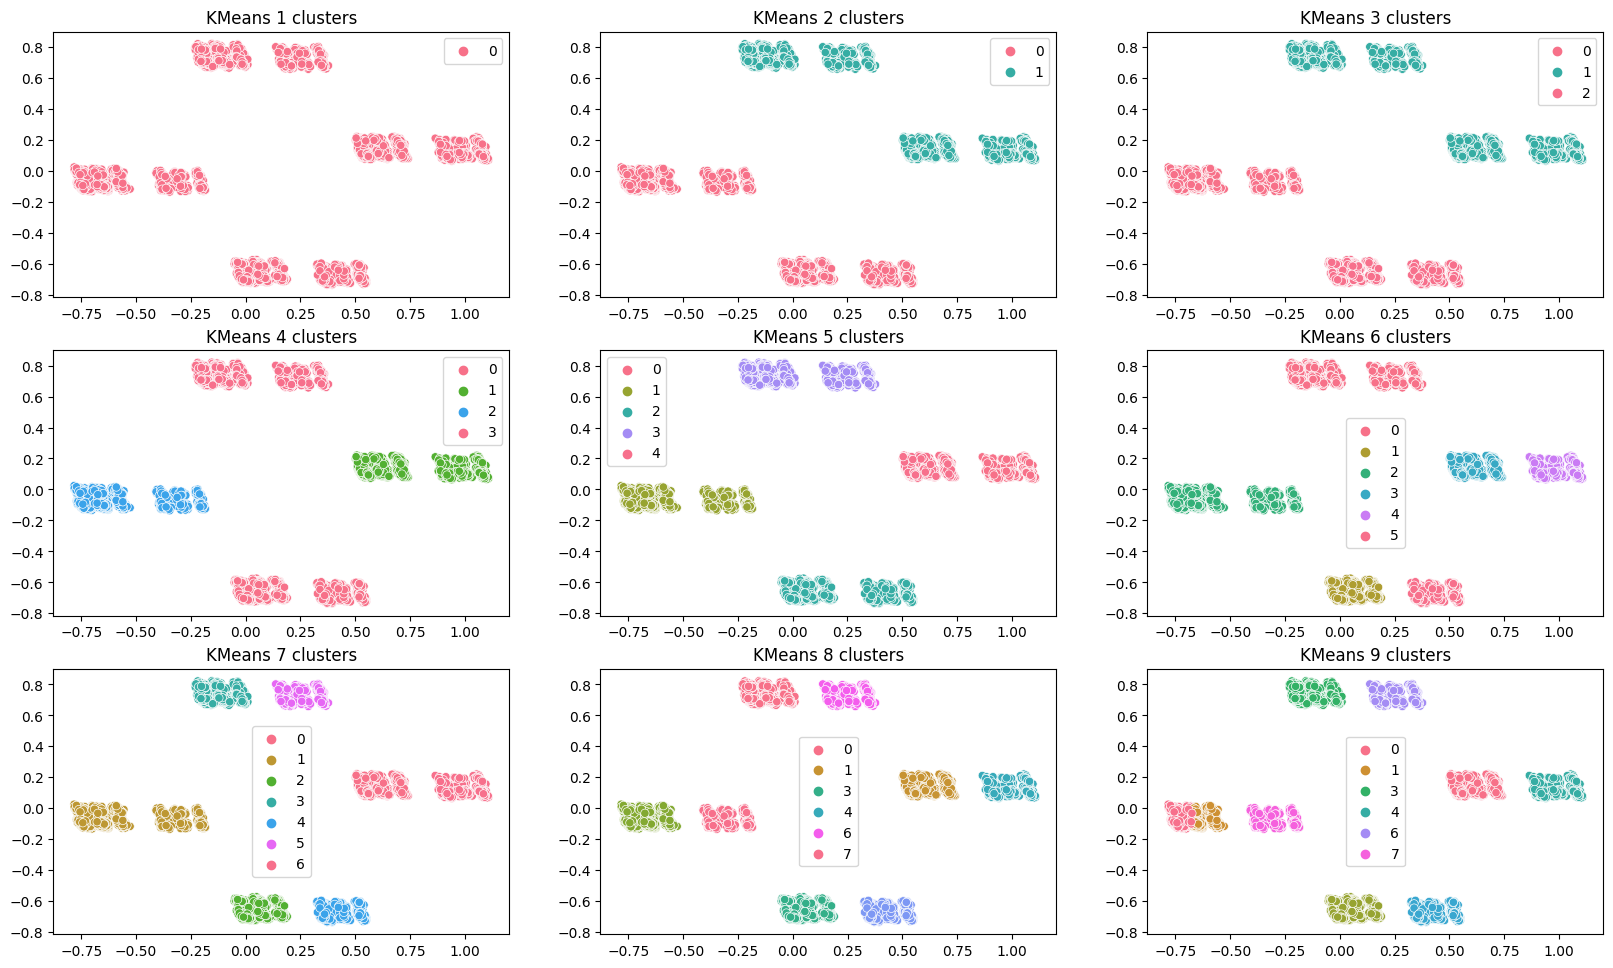

In [307]:
elbowPrinter(k_rng, sse)
print_elbow_KM(array_pca, array_km)

Ideas que estamos barajando:

- comparaciones entre columnas para buscar si algo es determinante
    - Satisfaction v/s Gender
    - Balance v/s Estimated Salary -> Creo que es la menos viable
    - Complain v/s satisfaction score
    - Card type v/s satisfaction score
    - Point Earned v/s Card Type
    - Point Earned v/s balance


## DBSCAN

[ 0  1  2 ... 24  3 20]


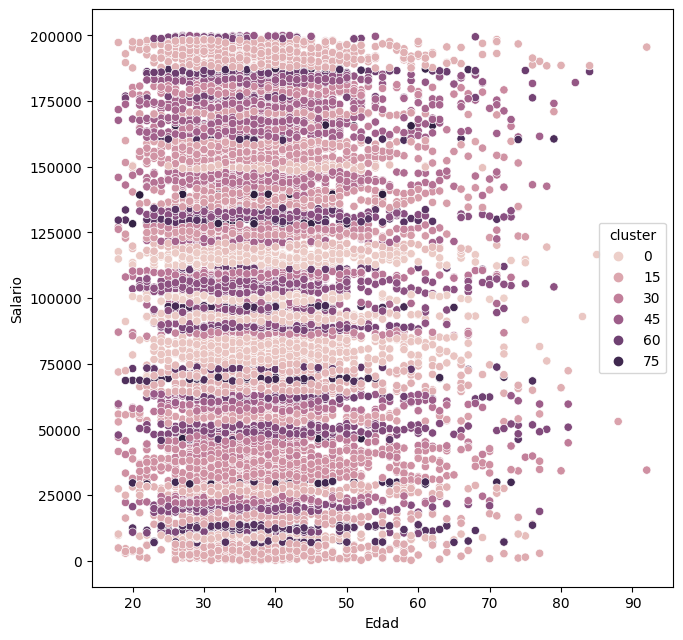

In [ ]:



def DBSCAN_core(og_dataframe, col1, col2):
    df = og_dataframe.loc[:,('age', 'estimatedsalary')]

    # intentando de escalar pa obtener algo...
    
    # scaler=MinMaxScaler()
    # scaler.fit(df[[col1]].values)
    # scaledData=scaler.transform((df[col1].values).reshape(-1,1))
    # df[col1]= scaledData

    # scaler.fit(df[[col2]].values)
    # scaledData=scaler.transform((df[col2].values).reshape(-1,1))
    # df[col2]= scaledData
    
    db_clusters=DBSCAN(eps = 100, min_samples=5).fit_predict(df[[col1,col2]])
    df["cluster"] = db_clusters
    print(db_clusters)
    return df

df = DBSCAN_core(bank_df, "age", "estimatedsalary")

plt.figure(figsize=(7.5, 7.5))
sns.scatterplot(data=df, x="age", y="estimatedsalary",  hue="cluster")
plt.xlabel("Edad")
plt.ylabel("Salario")

plt.show()

/var/folders/yv/w7n3_m554ys8hck5qrt3zbdc0000gn/T/ipykernel_13295/776840197.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x,y,  cmap="viridis")


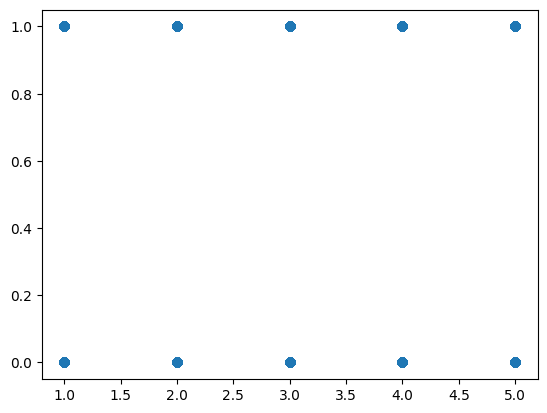

In [ ]:
# Existe alguna relacion entre el score de satisfaccion y el exited? 

x = bank_df["satisfaction_score"]
y = bank_df["exited"]


plt.scatter(x,y,  cmap="viridis")


In [ ]:
#plt.scatter(bank_df['CreditScore'], bank_df['Exited'])
print(bank_df[["geography", "exited"]].groupby("geography").count()) # cuantas personas de cada pais se van
print(bank_df[["gender", "exited"]].groupby("gender").count()) # cuantas personas por genero se van
print("\n")
print(bank_df['age'].describe()) # Edad de las personas
print("\n")
print(bank_df['tenure'].describe()) # Distribución del tiempo que llevan en el banco




           exited
geography        
France       5014
Germany      2509
Spain        2477
        exited
gender        
Female    4543
Male      5457


count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64


count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: tenure, dtype: float64


In [ ]:
# Existe algun valor del balance que indique que se fueron?

bank_df[["balance", "exited"]].groupby("exited").describe()


balance                                                          \
         count          mean           std  min         25%        50%   
exited                                                                   
0       7962.0  72742.750663  62851.577108  0.0      0.0000   92063.06   
1       2038.0  91109.476006  58346.483197  0.0  38591.2225  109344.23   

                                
                75%        max  
exited                          
0       126419.3300  221532.80  
1       131423.6375  250898.09

In [ ]:
# Existe un salario representativo para la gente que se va?
# Los grupos de las personas que se van tienen X plata...

bank_df[["estimatedsalary", "exited"]].groupby("exited").describe()

estimatedsalary                                                 \
                 count           mean           std    min        25%   
exited                                                                  
0               7962.0   99726.853141  57399.956717  90.07  50783.295   
1               2038.0  101509.908783  57932.623392  11.58  51924.020   

                                            
               50%          75%        max  
exited                                      
0        99620.355  148602.4450  199992.48  
1       102489.335  152443.8575  199808.10

In [ ]:
distribucionPorEdad= bank_df.groupby('age')['exited'].mean()*100
print(distribucionPorEdad)
print(type(distribucionPorEdad))

age
18     9.090909
19     3.703704
20     5.000000
21     5.660377
22    14.285714
        ...    
83     0.000000
84    50.000000
85     0.000000
88     0.000000
92     0.000000
Name: exited, Length: 70, dtype: float64
<class 'pandas.core.series.Series'>


In [ ]:
valores_filtrados = bank_df.loc[bank_df['age'] ==88, 'exited']
print(valores_filtrados)

2458    0
Name: exited, dtype: int64


## 2. Global Poverty and Inequality Dataset (35 pts)
Suponga que le solicitan generar una categorización de paises de acuerdo a sus características socio-demográficoas y socio-económicas en 5 grupos, aplique los métodos de clustering para clusterizar la información de los paises:



> ##### __2.1)__ De acuerdo a su experimentación, ¿es razonable hacer la categorización en 5 grupos para ese conjunto de datos o sugeriría una cantidad distinta?, fundamente experimentalmente su respuesta. (15 pts)
>


> ##### __2.2)__ De acuerdo a la cantidad escogida por usted en la pregunta anterior (ya sea que decidió quedarse con los 5 o una cantidad distinta) haga un análisis de los clusters explique qué características tienen los distintos grupos de paises encontrados. (10 pts)
>


> ##### __2.3)__ Muestre en un mapa del mundo la distribución de los clusters pintando cada país con el color correspondiente al cluster al que pertenece, ¿ve algún patrón? (le será útil usar la librería `geopandas`, acá un ejemplo de como usarla: [link](https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b)) (10 pts)

__Nota:__ Cuando explore el dataset se dará cuenta que cada país no aparece solo una vez sino que varias veces de acuerdo a cada año del cuál se tiene registro, trate esta información temporal como usted estime conveniente para poder resolver el problema enunciado al principio justificando su decisión.



## 3. E-Commerce Data (30)
Aplique el algoritmo apriori (puede encontrar una buena implementación en la librería `mlxtend`) sobre el conjunto de transacciones y obtenga los 100 itemsets más significativos.


Tenga en cuenta lo siguiente:

* Cada fila es un evento de compra/devolución de un producto realizado por un cliente, para evitar trabajar con las devoluciones elimine todas aquellas filas que contengan valores negativos de `Quantity` y `UnitPrice`.
* En el método apriori de `mlxtend` se pide que las transacciones sean procesadas con un transformador llamado `TransactionEncoder` el cual requiere que los conjuntos de articulos comprados en en una misma transaccion se presenten como una lista de productos, acá hay un ejemplo de dos transacciones en el formato requerido:
```
[['pan', 'mantequilla', 'mermelada'],
['trapero', 'lavaloza', 'polera', 'pantalon', 'cereales']]
```
Para poder hacer esto necesitará "agrupar" los elementos comprados según el código de la boleta (`InvoiceNo`).
* En las transacciones realizadas hay varios errores de ingreso del código del producto y la descripción del mismo, específicamente el problema está en que hay casos donde un código de producto está ligado a más de una descripción, sin embargo, solo una de las descripciones es la correcta: La más común, acá un par de ejemplos:



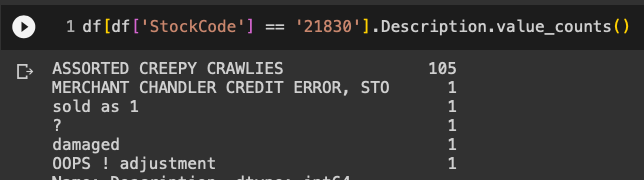




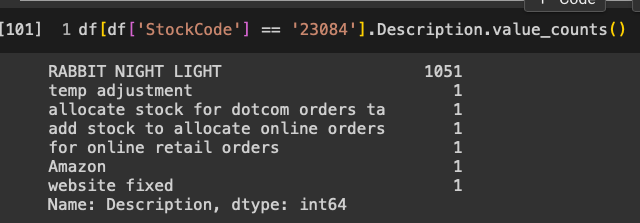

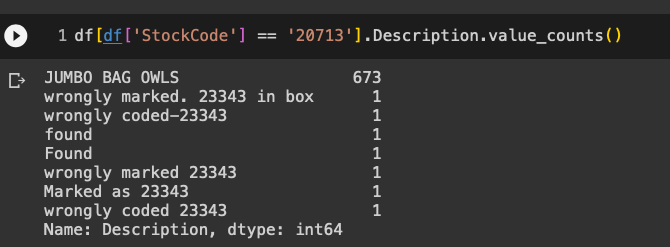

Preprocese adecuadamente las transacciones para quedarse solo con aquellas transacciones que tengan, para cada código de producto, la descripción más común encontrada para ese código. __No realizar esto implicará caer en una penalización de 15 pts.__

In [ ]:
print(ecom_df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [ ]:
negativePrice_df= ecom_df[ecom_df['UnitPrice']<=0] #Veremos cuantas filas tienen registros de precios=0 o negativos
negativePrice_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,12/8/2011 13:58,0.0,NaN,United Kingdom
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,12/8/2011 13:58,0.0,NaN,United Kingdom
538554,581408,85175,NaN,20,12/8/2011 14:06,0.0,NaN,United Kingdom


In [ ]:
negativeQuantity_df= ecom_df[ecom_df['Quantity']<=0] #Revisamos cuantas filas tienen cantidades de prod<=0
negativeQuantity_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


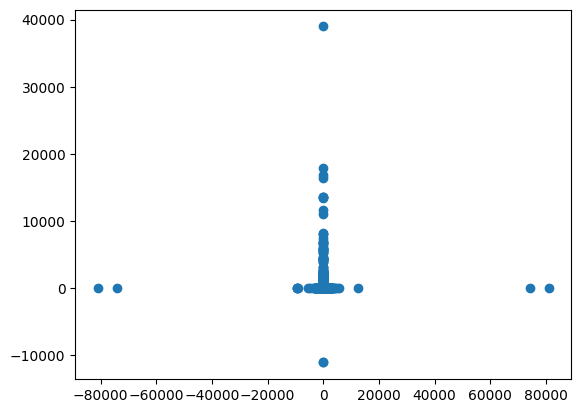

In [ ]:

plt.scatter(ecom_df['Quantity'], ecom_df['UnitPrice'])